# Explore PHANGS data

this Notebook explores the different data products that were produced by PHANGS.

In [1]:
# reload modules after they have been modified
%load_ext autoreload
%autoreload 2

# some basic packages
import os                 # filesystem related stuff
import json
from pathlib import Path  # use instead of os.path and glob
import sys                # mostly replaced by pathlib

import errno      # more detailed error messages
import warnings   # handles warnings
import logging    # use logging instead of print

from collections import OrderedDict  

# packages for scientific computing
import numpy as np
import scipy as sp

# packages for creating plots and figures
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# special functions for astronomy 
from astropy.table import Table,QTable  # useful datastructure
from astropy.table import vstack # combine multiple tables

from astropy.io import fits      # open fits files
from astropy.io import ascii     # handle normal files

from astropy.wcs import WCS               # handle coordinates
from astropy.coordinates import Angle     # work with angles (e.g. 1°2′3″)
from astropy.coordinates import SkyCoord  # convert pixel to sky coordinates
from astropy.visualization import simple_norm

from astropy.stats import sigma_clipped_stats  # calcualte statistics of images

import astropy.units as u        # handle units

from photutils import CircularAperture

from pymuse.constants import tab10, single_column, two_column
plt.style.use('TeX.mplstyle')

In [2]:
logging.basicConfig(stream=sys.stdout,
                    #format='(levelname)s %(name)s %(message)s',
                    datefmt='%H:%M:%S',
                    level=logging.INFO)

logger = logging.getLogger(__name__)

## Read in Data

In [3]:
name = 'NGC3351'

# first we need to specify the path to the raw data
data_raw = Path('d:\downloads\MUSEDAP')
basedir = Path('..')

### MUSE Data

In [4]:
from pymuse.io import ReadLineMaps

# read in the data we will be working with and print some information
galaxy = ReadLineMaps(data_raw / name)

INFO:pymuse.io:loading NGC3351
INFO:pymuse.io:replacing OIII5006 map
INFO:pymuse.io:file loaded with 4 extensions


### MUSE Cubes

In [285]:
data_raw = Path('g:\Archive')
filename = data_raw / 'MUSE' / 'MOSAIC' / name / f'{name}_DATACUBE_FINAL.fits'

with fits.open(filename , memmap=True, mode='denywrite') as hdul:
    #cube=SpectralCube(data=hdul[1].data,wcs=WCS(hdul[1].header))
    data_cube   = hdul[1].data
    cube_header = hdul[1].header

### Cluster Catalogue

In [5]:
with fits.open(basedir / 'data' / 'external' / 'Nebulae_Catalogue.fits') as hdul:
    nebulae = Table(hdul[1].data)

nebulae = nebulae[nebulae['gal_name']==name]    
nebulae.rename_columns(['cen_x','cen_y'],['x','y'])

### HST Data

In [ ]:
filename = extern / name / 'white_light_12nov2019' / f'{name}_white_24rgb.fits'

with fits.open(filename) as hdul:
    whitelight = hdul[0].data
    whitelight_header = hdul[0].header

In [104]:
extern = Path('g:\Archive\HST')

filename = extern / name / 'clusters_photometry_v0_9' / f'{name}_phangshst_cluster_allcandidates_v0_9.csv'

if filename.is_file():
    clusters = ascii.read(filename)
else:
    raise FileExistsError('no catalogue for ' + name)
    
clusters['SkyCoord'] = SkyCoord(clusters['PHANGS_RA']*u.degree,clusters['PHANGS_DEC']*u.degree)
x,y= clusters['SkyCoord'].to_pixel(wcs=galaxy.wcs)
clusters['x'] = x
clusters['y'] = y
clusters.rename_columns(['ID_PHANGS_CLUSTERS_V0_9','PHANGS_MASS_MINCHISQ','PHANGS_AGE_MINCHISQ','PHANGS_EBV_MINCHISQ'],
                        ['ID','mass','age','Ebv'])
clusters = clusters['ID','x','y','mass','age','Ebv','SkyCoord']
clusters['in_frame'] = False

y_dim,x_dim = galaxy.shape
for row in clusters:
    if 0<=int(row['x'])<x_dim and 0<=int(row['y'])<y_dim:
        if not np.isnan(galaxy.PSF[int(row['y']),int(row['y'])]):
            row['in_frame'] = True
            
clusters = clusters[clusters['in_frame'] & (clusters['mass']>1e3)]

## Compare MUSE and HST

In [ ]:
from astropy.nddata import Cutout2D

def compare_cutout(center,size,MUSE_data,HST_data,MUSE_wcs,HST_wcs):
    '''Compare the resolution of MUSE to HST'''
    
    cutout_MUSE = Cutout2D(MUSE_data,center,size,wcs=MUSE_wcs)
    cutout_HST  = Cutout2D(HST_data,center,size,wcs=HST_wcs)

    fig = plt.figure(figsize=(6.974,6.974/2))
    ax1 = fig.add_subplot(131,projection=MUSE_wcs)
    ax2 = fig.add_subplot(132,projection=cutout_MUSE.wcs)
    ax3 = fig.add_subplot(133,projection=cutout_HST.wcs)

    norm = simple_norm(MUSE_data,'linear',clip=False,percent=95)
    ax1.imshow(MUSE_data, origin='lower',norm=norm,cmap='Greys')

    norm = simple_norm(cutout_MUSE.data,'linear',clip=False,percent=95)
    ax2.imshow(cutout_MUSE.data, origin='lower',norm=norm,cmap='Greys')

    norm = simple_norm(cutout_HST.data,'linear',clip=False,percent=99)
    ax3.imshow(cutout_HST.data, origin='lower',norm=norm,cmap='Greys')

    (ymin,ymax),(xmin,xmax) = cutout_MUSE.bbox_original
    width  = xmax-xmin
    height = ymax-ymin

    ax1.add_patch(mpl.patches.Rectangle((xmin,ymin),width,height,linewidth=0.3,edgecolor='k',facecolor='none'))

    # format ticks with wcs
    # https://docs.astropy.org/en/stable/visualization/wcsaxes/ticks_labels_grid.html
    ax1.coords[0].set_ticks(number=3)
    ax1.coords[1].set_ticks(number=4)
    #ax2.coords[0].set_ticks(number=3)
    ax2.coords[1].set_ticklabel_visible(False)
    ax3.coords[1].set_ticklabel_visible(False)
    ax2.coords[0].set_ticklabel_visible(False)
    ax3.coords[0].set_ticklabel_visible(False)
    
    ax1.set(title='MUSE',
            xlabel='R.A. (J2000)',
            ylabel='Dec. (J2000)')

    ax2.set(title='MUSE cutout')
    ax3.set(title='HST cutout')
    
    # it is a bit tricky to get the coordinates right (because data uses the wcs coordinates)
    # the easiest thing is to use fractions from the figure size
    # https://matplotlib.org/3.1.3/api/_as_gen/matplotlib.patches.ConnectionPatch.html

    con = mpl.patches.ConnectionPatch(xyA=((xmax)/galaxy.shape[1],(ymax)/galaxy.shape[0]), xyB=(0,1), 
                                      coordsA="axes fraction", coordsB="axes fraction",
                                      axesA=ax1, axesB=ax2, color="black",linewidth=0.3)
    ax2.add_artist(con)
    con = mpl.patches.ConnectionPatch(xyA=((xmax)/galaxy.shape[1],(ymin)/galaxy.shape[0]), xyB=(0,0), 
                                      coordsA="axes fraction", coordsB="axes fraction",
                                      axesA=ax1, axesB=ax2, color="black",linewidth=0.3)
    ax2.add_artist(con)
    
    filename = basedir / 'reports' / 'cluster' / 'cutout.pdf'
    plt.savefig(filename,bbox_inches='tight',dpi=600)
    plt.show()
    
    
center = SkyCoord(ra='10h44m01.2s',dec='11d41m58.5s')
center = clusters[clusters['ID']==1278]['SkyCoord']
size   = 5*u.arcsec

compare_cutout(center,size,galaxy.whitelight,whitelight,galaxy.wcs,WCS(whitelight_header))

## Combine data

In [ ]:
from pymuse.detection import match_catalogues

idx, sep = match_catalogues(clusters[['x','y']],nebulae[['x','y']])

tolerance = 5
within_tolerance = len(sep[sep<tolerance])

print(f'{within_tolerance} of {len(sep)} match within {tolerance}: {within_tolerance / len(sep)*100:.1f} %')
print(f'mean seperation is {sep[sep<tolerance].mean():.2f}')

clusters['sep'] = sep
clusters['Z'] = nebulae[idx]['met_scal']
clusters['Z_without_radial'] = nebulae[idx]['Delta_met']

In [ ]:
from pymuse.plot.plot import create_RGB

#HII = nebulae[nebulae['HII_region_class']==1]

fig = plt.figure(figsize=(8,8))
ax  = fig.add_subplot(projection=galaxy.wcs)

norm = simple_norm(galaxy.OIII5006_DAP,clip=False,percent=99)
#img = create_RGB(galaxy.HA6562,galaxy.OIII5006_DAP,galaxy.SII6716,weights=[0.6,1,0.6],percentile=[95,99.,95])
#ax.imshow(galaxy.OIII5006_DAP,norm=norm,cmap=plt.cm.Blues)
#ax.imshow(img)

ax.scatter(clusters['x'],clusters['y'],marker='o',s=5,lw=0.3,color='black',alpha=0.6,label='cluster')
im = ax.scatter(nebulae['x'],nebulae['y'],marker='o',s=5,lw=0.3,
           c=nebulae['met_scal'], cmap=plt.cm.coolwarm,alpha=0.9,label='nebulae')
plt.colorbar(im)
plt.legend()
print(f'{len(nebulae)} HII regions\n{len(clusters)} Clusters')

plt.savefig('clusters+HII.pdf',dpi=500)

In [ ]:
#img = create_RGB(galaxy.HA6562,galaxy.OIII5006_DAP,galaxy.SII6716,weights=[0.6,1,0.6],percentile=[95,99.,95])

fig = plt.figure(figsize=(8,8))
ax  = fig.add_subplot(projection=galaxy.wcs)

img = galaxy.OIII5006
norm = simple_norm(img,'linear',clip=False,percent=99)
ax.imshow(img,norm=norm,cmap=plt.cm.Greens)
ax.scatter(x,y,marker='o',s=1,lw=0.5,edgecolor='orange',facecolors='none')

PN = tbl[c_PN & c_limit]
ax.scatter(PN['x'],PN['y'],marker='o',s=3,lw=0.3,edgecolor='tab:red',facecolors='none')

plt.savefig('clusters.pdf',dpi=1000)
#norm = simple_norm(galaxy.OIII5006_DAP,clip=False,max_percent=95)


In [ ]:
crit = clusters['sep']<5
plt.scatter(clusters[crit]['mass'],clusters[crit]['Z'])
plt.xscale('log')
plt.show()

## Plot Spectra of different Objects

In [143]:
from pymuse.auxiliary import circular_mask

filename = basedir / 'data' / 'catalogues' / f'pn_candidates_{name}.txt'
nebulae = ascii.read(filename,format='fixed_width',delimiter='\t')

pn  = nebulae[nebulae['type']=='PN']
HII = nebulae[nebulae['type']=='HII']
SNR = nebulae[nebulae['type']=='SNR']

In [199]:
from functools import reduce

NOBJ = 5
radius = 2
pn.sort('mOIII')
mask = mask = reduce((lambda x,y: x|y),[circular_mask(*galaxy.shape,(pn['x'][idx],pn['y'][idx]),radius=radius) for idx in range(NOBJ)])
pn_spectra = np.sum(data_cube[...,mask],axis=1)
print('PN done')

HII.sort('mOIII')
mask = mask = reduce((lambda x,y: x|y),[circular_mask(*galaxy.shape,(HII['x'][idx],HII['y'][idx]),radius=radius) for idx in range(20,20+NOBJ)])
HII_spectra = np.sum(data_cube[...,mask],axis=1)
print('HII done')

SNR.sort('mOIII')
mask = mask = reduce((lambda x,y: x|y),[circular_mask(*galaxy.shape,(SNR['x'][idx],SNR['y'][idx]),radius=radius) for idx in range(NOBJ)])
SNR_spectra = np.sum(data_cube[...,mask],axis=1)
print('SNR done')

PN done
HII done
SNR done


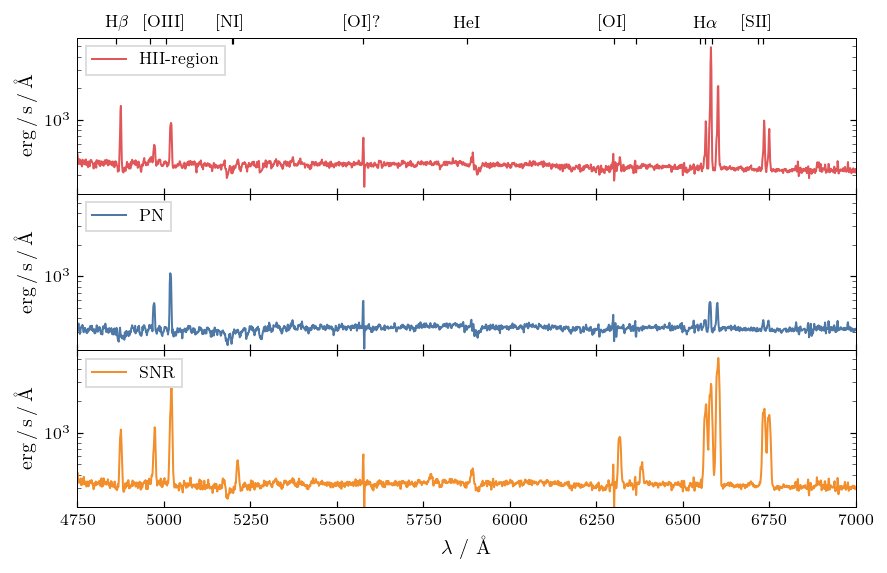

In [341]:
WAVELMIN=  4749.8759765625       
WAVELMAX=  9349.8759765625 

wlen = np.linspace(WAVELMIN,WAVELMAX,data.shape[0]) #* u.nanometer

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, sharex=True,figsize=(two_column,two_column/1.618))


ax1.plot(wlen,HII_spectra/NOBJ,label='HII-region',color=tab10[0])
ax1.legend(loc=2)
ax2.plot(wlen,pn_spectra/NOBJ,label='PN',color=tab10[1])
ax2.legend(loc=2)
ax3.plot(wlen,SNR_spectra/NOBJ,label='SNR',color=tab10[2])
ax3.legend(loc=2)

ylim = [200,6e3]
xlim = [4750,7000]
scale = 'log'
ax1.set(ylabel=r'erg\,/\,s\,/\,\AA',
        yscale=scale,
        xlim=xlim,
        ylim=ylim
      )
ax2.set(ylabel=r'erg\,/\,s\,/\,\AA',
        yscale=scale,
        xlim=xlim,
        ylim=ylim
      )
ax3.set(xlabel=r'$\lambda$ / \AA',
       ylabel=r'erg\,/\,s\,/\,\AA',
       yscale=scale,
       xlim=xlim,
       ylim=ylim
      )

ticks  = [4863,4960,5007,5197,5200,5577,5877,6302,6366,6550,6565,6585,6718,6733] 
labels = [r'H$\beta$','','[OIII]','[NI]','','[OI]?','HeI','[OI]','','',r'H$\alpha$','','[SII]','']
ax4 = ax1.twiny()
ax4.set_xticks(ticks,minor=False)
ax4.set_xticklabels(labels)
ax4.set_xlim(xlim)
    
plt.subplots_adjust(hspace = .001)
filename = basedir / 'reports' / 'cluster' / 'spectra_nebulae.pdf'
plt.savefig(filename,bbox_inches='tight',dpi=600)

## Spectra of one pixel

0

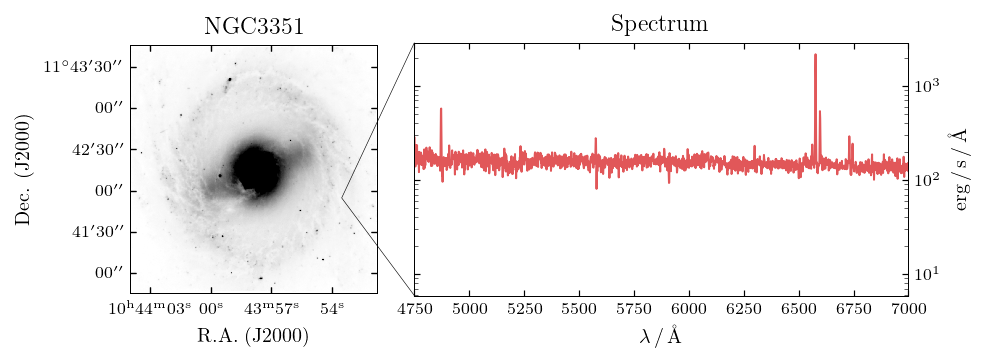

In [340]:

def cutout_spectrum(position,img,data_cube,wcs,title=None):
    '''Plot one spectra of a MUSE data cube with Image
    
    Parameters
    ----------
    
    position :
        Tuple of coordinates or SkyCoord object. Object at
        which the spectra is extracted.
        
    img : 
        2D Image that is displayed to illustrate the position
        of the spectra
        
    data_cube :
        3D data cube (spectra is first dimension) with the 
        same shape as img
        
    wcs : 
        World coordinate information for img and data_cube
        
    title : str (optional)
        Set title for plot
    '''
    
    
    if isinstance(position,SkyCoord):
        x,y = position.to_pixel(wcs=wcs)
    else:
        x,y = position
        
    # plot it
    fig = plt.figure(figsize=(two_column,two_column/3)) 
    gs = mpl.gridspec.GridSpec(1, 2, width_ratios=[1,2]) 
    ax1 = fig.add_subplot(gs[0],projection=galaxy.wcs)

    norm = simple_norm(img,'linear',clip=False,percent=95)
    ax1.imshow(img, origin='lower',norm=norm,cmap='Greys')
    
    spectra = np.sum(data_cube[...,int(x)-1:int(x)+1,int(y)-1:int(y)+1],axis=(1,2))    
    # the wavelenght coverage of MUSE
    wavelength = np.linspace(4749.88,9349.88,data_cube.shape[0]) 
    
    ax2 = fig.add_subplot(gs[1])
    ax2.plot(wavelength,spectra,color=tab10[0])
    
    ax1.set(title=title,
            xlabel='R.A. (J2000)',
            ylabel='Dec. (J2000)')
    
    ax2.set(title='Spectrum',
            yscale='log',
            xlim=[4750,7000],
            #ylim=[1e2,7e2],
            xlabel=r'$\lambda$\,/\,\AA',
            ylabel=r'erg\,/\,s\,/\,\AA')
    
    ax2.yaxis.tick_right()
    ax2.yaxis.set_ticks_position('both')
    ax2.yaxis.set_label_position("right")
    
    
    ax1.add_patch(mpl.patches.Rectangle((x,y),1,1,linewidth=0.3,edgecolor='k',facecolor='none'))
    plt.subplots_adjust(wspace=0.1)
    
    x = int(x)
    y = int(y)
    con = mpl.patches.ConnectionPatch(xyA=((x+1)/galaxy.shape[1],(y+1)/galaxy.shape[0]), xyB=(0,1), 
                                      coordsA="axes fraction", coordsB="axes fraction",
                                      axesA=ax1, axesB=ax2, color="black",linewidth=0.3)
    ax2.add_artist(con)
    con = mpl.patches.ConnectionPatch(xyA=((x+1)/galaxy.shape[1],(y)/galaxy.shape[0]), xyB=(0,0), 
                                      coordsA="axes fraction", coordsB="axes fraction",
                                      axesA=ax1, axesB=ax2, color="black",linewidth=0.3)
    ax2.add_artist(con)
    
    filename = basedir / 'reports' / 'cluster' / 'cutout_spectrum.pdf'
    plt.savefig(filename,bbox_inches='tight',dpi=800)
    return 0
   
# position can be SkyCoord or (x,y) tuple
position = clusters[clusters['ID']==167]['SkyCoord']
position = pn[['x','y']][0]

cutout_spectrum(position,galaxy.whitelight,data_cube,galaxy.wcs,galaxy.name)


## Starburst99


In [ ]:
try:
    from starburst99.io import Cluster  
except ImportError:
    print('Package `starburst99` not installed')
    
star_path = Path('../../Starburst99/data')
noutput = 'cluster'

cluster1e4 = Cluster(star_path / 'GENEVA_v40_0.014_1e4Msun' / noutput)
cluster1e6 = Cluster(star_path / 'GENEVA_v40_0.014_1e6Msun' / noutput)
cluster_new = cluster1e4.scale(1e6)

### Compare results of the scaling

In [ ]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot()

tablename = 'ewidth'

tbl1 = getattr(cluster1e4,tablename)
tbl2 = getattr(cluster1e6,tablename)
tbl3 = getattr(cluster_new,tablename)

for col in tbl1.columns[1:]:
    color = next(ax._get_lines.prop_cycler)['color']
    
    ax.plot(tbl1['Time'],tbl1[col],color=color,ls='--',label=col.replace('_',''))
    ax.plot(tbl2['Time'],tbl2[col],color=color,ls=':',lw=2)
    ax.plot(tbl3['Time'],tbl3[col],color=color,lw=0.5)

#ax.set_yscale('log')
plt.legend()
plt.show()

In [ ]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot()

tablename = 'quanta'
column = 'HI_rate'
tbl1 = getattr(cluster_new,tablename)
tbl2 = getattr(cluster1e6,tablename)


color = next(ax._get_lines.prop_cycler)['color']
    
ax.plot(tbl1['Time'],tbl1[column],color=color)
ax.plot(tbl2['Time'],tbl2[column],color=color,ls='--',lw=2)

ax.set_yscale('log')
#plt.legend()
plt.show()